In [1]:
from data import read_df_with_transfer_learning_subset
from train import *
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

Using TensorFlow backend.


In [2]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = read_df_with_transfer_learning_subset()

In [3]:
print(df_domain_train.shape)
print(df_domain_test.shape)
print(df_domain_transfer_learning_train.shape)
print(df_domain_transfer_learning_test.shape)

(4251, 36)
(373, 36)
(70, 36)
(30, 36)


In [4]:
print('TRAIN:')
for line in ['Maize_Line_Mixed','Maize_Line_Non_Stiff_Stalk','Maize_Line_Popcorn','Maize_Line_Stiff_Stalk','Maize_Line_Sweet_Corn','Maize_Line_Tropical']:
    count=df_domain_transfer_learning_train.loc[:,line]
    print(line + ': ' + str(sum(count)/len(count)))
print('age:' + str(df_domain_transfer_learning_train.loc[:,'age'].mean()))
print('rain:' + str(df_domain_transfer_learning_train.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_transfer_learning_train.loc[:,'Temperature'].mean()))
    
print('TEST:')
for line in ['Maize_Line_Mixed','Maize_Line_Non_Stiff_Stalk','Maize_Line_Popcorn','Maize_Line_Stiff_Stalk','Maize_Line_Sweet_Corn','Maize_Line_Tropical']:
    count=df_domain_transfer_learning_test.loc[:,line]
    print(line + ': ' + str(sum(count)/len(count)))
print('age:' + str(df_domain_transfer_learning_test.loc[:,'age'].mean()))
print('rain:' + str(df_domain_transfer_learning_test.loc[:,'Precipitation3Days'].mean()))
print('Tª:' + str(df_domain_transfer_learning_test.loc[:,'Temperature'].mean()))

TRAIN:
Maize_Line_Mixed: 0.05714285714285714
Maize_Line_Non_Stiff_Stalk: 0.3142857142857143
Maize_Line_Popcorn: 0.02857142857142857
Maize_Line_Stiff_Stalk: 0.1
Maize_Line_Sweet_Corn: 0.04285714285714286
Maize_Line_Tropical: 0.45714285714285713
age:9.842857142857143
rain:0.4024285714285715
Tª:70.44571428571427
TEST:
Maize_Line_Mixed: 0.13333333333333333
Maize_Line_Non_Stiff_Stalk: 0.26666666666666666
Maize_Line_Popcorn: 0.06666666666666667
Maize_Line_Stiff_Stalk: 0.13333333333333333
Maize_Line_Sweet_Corn: 0.0
Maize_Line_Tropical: 0.4
age:9.933333333333334
rain:0.3903333333333334
Tª:69.72333333333333


# Linear regression transfer_learning subset (domain-microbiome)

### Get numpy transfer_learning objects

In [5]:
data_microbioma_transfer_learning_train = df_microbioma_transfer_learning_train.to_numpy(dtype=np.float32)
data_microbioma_transfer_learning_test = df_microbioma_transfer_learning_test.to_numpy(dtype=np.float32)
data_domain_transfer_learning_train = df_domain_transfer_learning_train.to_numpy(dtype=np.float32)
data_domain_transfer_learning_test = df_domain_transfer_learning_test.to_numpy(dtype=np.float32)

In [6]:
def model(shape_in, shape_out, output_transform):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    #for s in layers_list:
    #    net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [7]:
def model_fn():
    m = model(shape_in=36,
              shape_out=717,
              output_transform=None)
              #layers_list=[128,256],
              #activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [8]:
latent_space = 0
results, modelsLR = train(model_fn,
                        data_microbioma_transfer_learning_train,
                        data_domain_transfer_learning_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>99</b></p>

<b>loss</b>: 4.5249 (min: 4.4434, max: 4.6996)

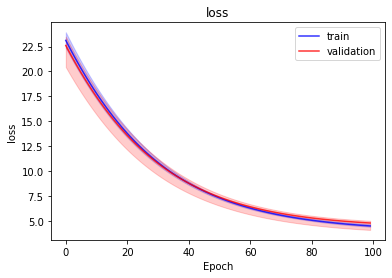

<b>domain_BrayCurtis</b>: 0.5389 (min: 0.5081, max: 0.6002)

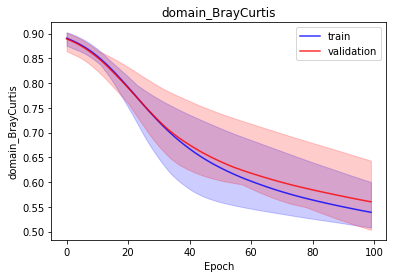

<b>domain_pearson_corr</b>: 0.5710 (min: 0.3979, max: 0.6518)

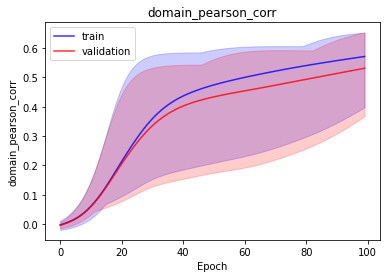

<b>domain_jensen_shannon_divergence</b>: 1.3182 (min: 1.1731, max: 1.4832)

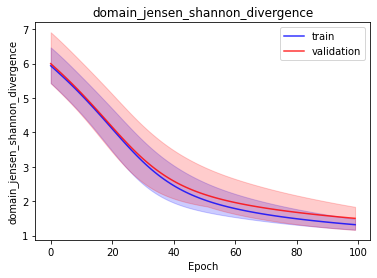

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 4.524889087677002 | 4.443427562713623 | 4.699603080749512 |
| domain_BrayCurtis | 0.5389026403427124 | 0.5081192851066589 | 0.6001900434494019 |
| domain_pearson_corr | 0.5709863901138306 | 0.397946298122406 | 0.651787281036377 |
| domain_jensen_shannon_divergence | 1.318185806274414 | 1.1730588674545288 | 1.483245849609375 |


[('best_lost_epoch', 99),
 ('val_loss', [4.81808443069458, 4.126952648162842, 5.040627479553223]),
 ('val_domain_BrayCurtis', [0.56017464, 0.5032855, 0.6433539]),
 ('val_domain_pearson_corr', [0.530938, 0.36826557, 0.6535489]),
 ('val_domain_jensen_shannon_divergence', [1.5017664, 1.1659515, 1.8370152])]

In [9]:
print_results(results)

In [10]:
def test_model(models, input_transform, output_transform, bioma_transfer_test, domain_transfer_test):
    data_bioma_test_transformed = Percentage()(bioma_transfer_test)
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for cv_models in models:
        model, _, _, _ = cv_models
        predictions = model.predict(domain_transfer_test)
        for m in metrics:
            if m.name not in metrics_results:
                metrics_results[m.name] = []
            result = m(bioma_transfer_test, predictions)
            m.reset_states()
            metrics_results[m.name].append(result.numpy())
        predictions = tf.nn.softmax(predictions)
        all_predictions.append(predictions)
        # otus error
        se = tf.math.squared_difference(predictions, data_bioma_test_transformed)
        mse = tf.reduce_mean(se, axis=0)
        otus_errors.append(mse)
    mse_otus = tf.reduce_mean(tf.stack(otus_errors, axis=0), axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

#     md_text ="### Best Otus\n"
#     md_text += "| OTU | mse |\n"
#     md_text += "|:----|----:|\n"
#     for v, k in mse_otus_keys[:10]:
#         md_text += "| {} | {} |\n".format(k, v)
#     md_text += "\n\n"
#     md_text +="### Worst Otus\n"
#     md_text += "| OTU | mse |\n"
#     md_text += "|:----|----:|\n"
#     for v, k in reversed(mse_otus_keys[-10:]):
#         md_text += "| {} | {} |\n".format(k, v)

#     display(Markdown(md_text))
    
    final_predictions = np.mean(all_predictions,axis=0)
    return final_predictions

In [11]:
predictions = test_model(modelsLR, CenterLogRatio, None, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_linear_regresion.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.556740939617157 | 0.5289128422737122 | 0.6269718408584595 |
| pearson_corr | 0.5474282503128052 | 0.36929842829704285 | 0.6365534663200378 |
| jensen_shannon_divergence | 1.5805952548980713 | 1.3788732290267944 | 1.7486435174942017 |


# MLP (Dense) transfer_learning subset (domain-microbiome)

In [255]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [262]:
def model_fn():
    m = model(shape_in=36,
              shape_out=717,
              output_transform=None,
              layers_list=[128,512],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [263]:
latent_space=0
results, modelsMLP = train(model_fn,
                        data_microbioma_transfer_learning_train,
                        data_domain_transfer_learning_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>95</b></p>

<b>loss</b>: 3.7151 (min: 3.6374, max: 3.8974)

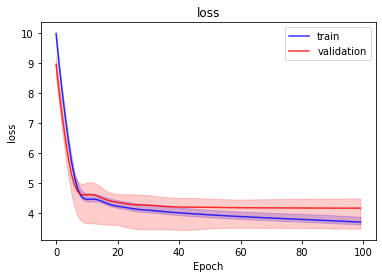

<b>domain_BrayCurtis</b>: 0.4344 (min: 0.4278, max: 0.4420)

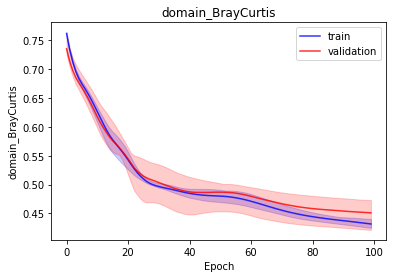

<b>domain_pearson_corr</b>: 0.7112 (min: 0.7027, max: 0.7186)

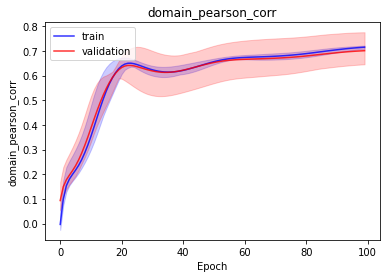

<b>domain_jensen_shannon_divergence</b>: 0.8383 (min: 0.8220, max: 0.8714)

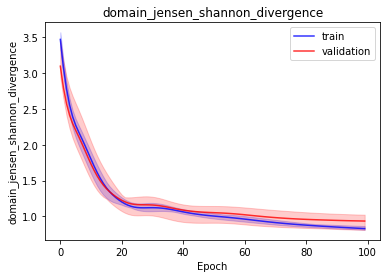

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 3.7151097297668456 | 3.6374435424804688 | 3.897383451461792 |
| domain_BrayCurtis | 0.43442025780677795 | 0.4277547299861908 | 0.44198861718177795 |
| domain_pearson_corr | 0.7112127542495728 | 0.7027086615562439 | 0.7186451554298401 |
| domain_jensen_shannon_divergence | 0.8383243680000305 | 0.8219982385635376 | 0.8714308142662048 |


[('best_lost_epoch', 95),
 ('val_loss', [4.161158657073974, 3.4784083366394043, 4.4780073165893555]),
 ('val_domain_BrayCurtis', [0.45238414, 0.4231874, 0.47428703]),
 ('val_domain_pearson_corr', [0.69784147, 0.64229923, 0.77422374]),
 ('val_domain_jensen_shannon_divergence', [0.93828696, 0.8159685, 1.0282934])]

In [264]:
print_results(results)

In [265]:
predictions = test_model(modelsMLP, CenterLogRatio, None, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.45099347829818726 | 0.43953755497932434 | 0.4580453932285309 |
| pearson_corr | 0.6957882046699524 | 0.6769720315933228 | 0.7077251672744751 |
| jensen_shannon_divergence | 1.072880506515503 | 1.0604100227355957 | 1.0863935947418213 |


In [266]:
predictions

array([[1.89058308e-04, 6.27052577e-06, 2.96820235e-03, ...,
        3.92023367e-06, 1.68738253e-02, 6.36600744e-05],
       [2.09797901e-04, 6.47068373e-06, 2.05877284e-03, ...,
        4.56751559e-06, 2.79020369e-02, 5.35780382e-05],
       [2.04697673e-04, 5.85045336e-06, 5.51710429e-04, ...,
        5.82900384e-06, 8.59837383e-02, 2.57998145e-05],
       ...,
       [6.01847714e-05, 6.17825572e-06, 2.97767197e-04, ...,
        4.79827077e-06, 1.00033864e-01, 5.21250377e-06],
       [1.79022347e-04, 5.54677717e-06, 3.71706963e-04, ...,
        6.17311798e-06, 1.00101151e-01, 2.04971293e-05],
       [2.00924536e-04, 6.34337039e-06, 1.17241079e-03, ...,
        5.32067997e-06, 5.10935076e-02, 4.06989820e-05]], dtype=float32)

# Autoencoder transfer_learning subset (domain-microbiome)

### Get numpy train objects

In [18]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)

### To create auto-encoder combined model

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 10 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>88</b></p>

<b>loss</b>: 0.6281 (min: 0.6281, max: 0.6281)

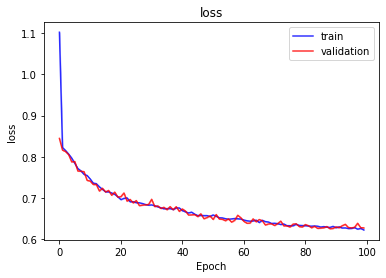

<b>bioma_loss</b>: 0.2035 (min: 0.2035, max: 0.2035)

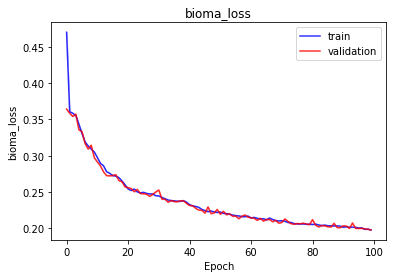

<b>domain_loss</b>: 0.4066 (min: 0.4066, max: 0.4066)

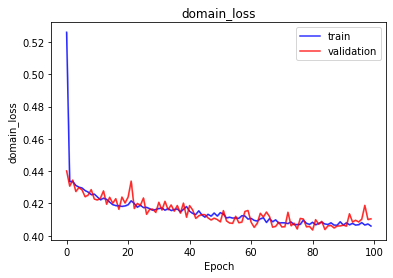

<b>latent_loss</b>: 0.0181 (min: 0.0181, max: 0.0181)

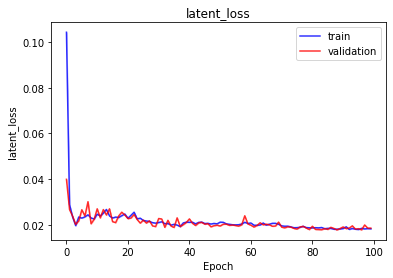

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

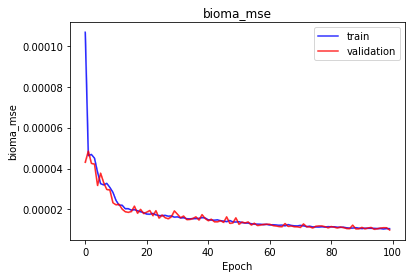

<b>bioma_mae</b>: 0.0006 (min: 0.0006, max: 0.0006)

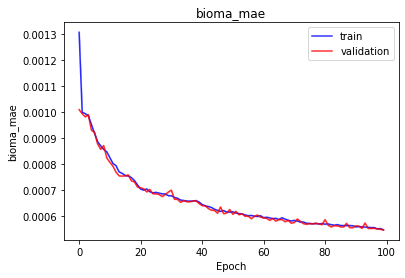

<b>bioma_mape</b>: 4990.9136 (min: 4990.9136, max: 4990.9136)

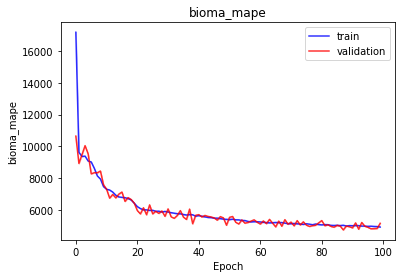

<b>bioma_BrayCurtis</b>: 0.2037 (min: 0.2037, max: 0.2037)

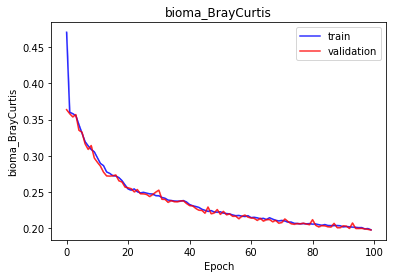

<b>bioma_pearson_corr</b>: 0.9189 (min: 0.9189, max: 0.9189)

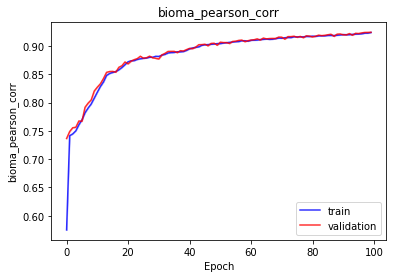

<b>bioma_jensen_shannon_divergence</b>: 0.3575 (min: 0.3575, max: 0.3575)

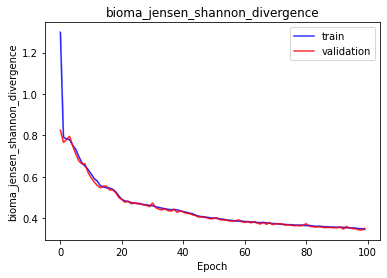

<b>domain_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

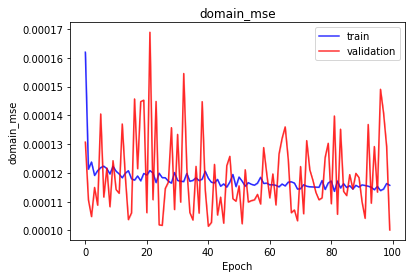

<b>domain_mae</b>: 0.0011 (min: 0.0011, max: 0.0011)

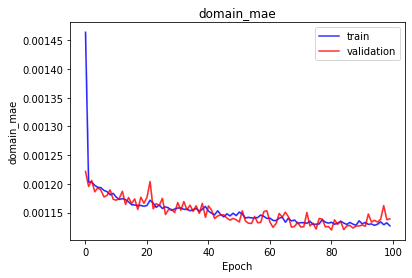

<b>domain_mape</b>: 8071.3364 (min: 8071.3364, max: 8071.3364)

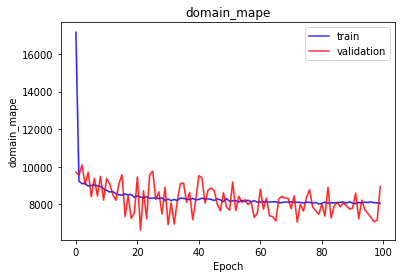

<b>domain_BrayCurtis</b>: 0.4063 (min: 0.4063, max: 0.4063)

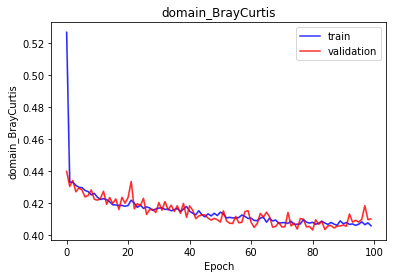

<b>domain_pearson_corr</b>: 0.7299 (min: 0.7299, max: 0.7299)

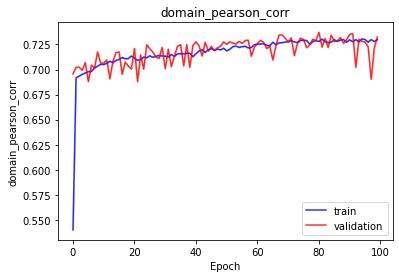

<b>domain_jensen_shannon_divergence</b>: 0.8937 (min: 0.8937, max: 0.8937)

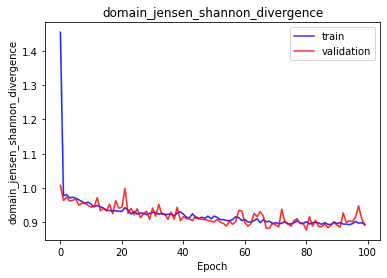

<b>latent_mae</b>: 0.0181 (min: 0.0181, max: 0.0181)

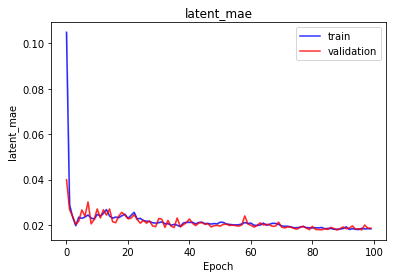

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.6281308365468277 | 0.6281308365468277 | 0.6281308365468277 |
| bioma_loss | 0.20353731513023376 | 0.20353731513023376 | 0.20353731513023376 |
| domain_loss | 0.40655675530433655 | 0.40655675530433655 | 0.40655675530433655 |
| latent_loss | 0.018124405294656754 | 0.018124405294656754 | 0.018124405294656754 |
| bioma_mse | 1.11272174763144e-05 | 1.11272174763144e-05 | 1.11272174763144e-05 |
| bioma_mae | 0.0005624765763059258 | 0.0005624765763059258 | 0.0005624765763059258 |
| bioma_mape | 4990.91357421875 | 4990.91357421875 | 4990.91357421875 |
| bioma_BrayCurtis | 0.2036895602941513 | 0.2036895602941513 | 0.2036895602941513 |
| bioma_pearson_corr | 0.918918788433075 | 0.918918788433075 | 0.918918788433075 |
| bioma_jensen_shannon_divergence | 0.3575323224067688 | 0.3575323224067688 | 0.3575323224067688 |
| domain_mse | 0.00011569513299036771 | 0.00011569513299036771 | 0.00011569513299036771 |
| domain_mae | 0.0011279369937255979 | 0.0011279369937255979 | 0.0011279369937255979 |
| domain_mape | 8071.33642578125 | 8071.33642578125 | 8071.33642578125 |
| domain_BrayCurtis | 0.40633508563041687 | 0.40633508563041687 | 0.40633508563041687 |
| domain_pearson_corr | 0.7299425005912781 | 0.7299425005912781 | 0.7299425005912781 |
| domain_jensen_shannon_divergence | 0.8937239050865173 | 0.8937239050865173 | 0.8937239050865173 |
| latent_mae | 0.018106121569871902 | 0.018106121569871902 | 0.018106121569871902 |


*************

In [19]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        show_results=True, 
                        device='/CPU:0')

### To get encoders and decoders to use in transfer learning model

In [20]:
models[0]

(<tensorflow.python.keras.engine.training.Model at 0x7f38c44b86d8>,
 <tensorflow.python.keras.engine.training.Model at 0x7f38c4492518>)

In [21]:
model, encoder, encoder_domain, decoder = models[0]

### To predict latent space for samples in transfer learning Walters et al. subset

In [22]:
latent_transfer_learning_train = encoder.predict(data_microbioma_transfer_learning_train)
latent_transfer_learning_test = encoder.predict(data_microbioma_transfer_learning_test)

### To build model to predict latent space 
Dense model, with transfer_learning_train. With input=domain, output=10 neuronas latent space (activation function output=activation_latent='tanh')

In [247]:
def model_fn_tl():
    in_layer = layers.Input(shape=(36,))
    net = layers.Dense(64, activation='tanh')(in_layer)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_transfer_learning_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [248]:
def train_tl_noEnsemble(model_fn,
          data_latent_train,
          data_latent_val,
          data_domain_train,
          data_domain_val,
          epochs=100,
          batch_size=16,
          random_seed=347,
          verbose=0):
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]

    tf.random.set_seed(random_seed)

    y_train, y_val = data_latent_train, data_latent_val
    x_train, x_val = data_domain_train, data_domain_val
    model = model_fn()
    metrics_prefix = 'domain'

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
            batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        
        
    r = model.fit(train_dataset,
                  epochs=epochs,
                  validation_data=val_dataset,
                  callbacks=train_callbacks,
                  verbose=0)
    if metrics_prefix is not None:
        old_keys = r.history
        r.history = {}
        for k, v in old_keys.items():
            if k == 'loss' or k == 'val_loss':
                new_key = k
            elif k.startswith('val_'):
                new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
            else:
                new_key = '{}_{}'.format(metrics_prefix, k)
            r.history[new_key] = v
    return r, model

In [249]:
result_tl, model_tl = train_tl_noEnsemble(model_fn_tl,
                            latent_transfer_learning_train,
                            latent_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            data_domain_transfer_learning_train,
                            epochs=100,
                            batch_size=64,
                            verbose=-1)
#print_results(result_tl)
print(result_tl)

In [250]:
model_tl

In [251]:
def test_model_tl_latent(model, latent_transfer_test, domain_transfer_test):

    metrics_results = {}

    final_predictions = model.predict(domain_transfer_test)
    
    result = se = tf.math.squared_difference(final_predictions, latent_transfer_test)
    metrics_results['mse'] =result.numpy()

    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
       md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])
    
    display(Markdown(md_text))
    
    return predictions

In [252]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_tl, latent_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP_domain-latent_test.txt')


## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.0007845326326787472 | 1.1404126531999736e-08 | 0.011486619710922241 |


## Domain -> latent -> microbiome. Test set transfer_learning
### Only 1 latent space

In [253]:
def test_model_tl_noEnsemble(model, decoder, input_transform, output_transform, bioma_transfer_test, domain_transfer_test):
    data_bioma_test_transformed = Percentage()(bioma_transfer_test)
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    final_predictions = model.predict(domain_transfer_test)
    
    final_decoded = decoder.predict(final_predictions)
    
    predictions = tf.nn.softmax(final_decoded)
    
    for m in metrics:
        if m.name not in metrics_results:
            metrics_results[m.name] = []
        result = m(bioma_transfer_test, final_decoded)
        metrics_results[m.name] =result.numpy()
    # otus error
    se = tf.math.squared_difference(final_decoded, data_bioma_test_transformed)
    mse_otus = tf.reduce_mean(se, axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])

    display(Markdown(md_text))
    
    return predictions

### a) With model_TL

In [254]:
predictions = test_model_tl_noEnsemble(model_tl, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.446624755859375 | 0.446624755859375 | 0.446624755859375 |
| pearson_corr | 0.6974228024482727 | 0.6974228024482727 | 0.6974228024482727 |
| jensen_shannon_divergence | 1.1130696535110474 | 1.1130696535110474 | 1.1130696535110474 |


### b) With the encoder_domain (best case)

In [31]:
# Test with encoder_biome, en vez de model_tl
predictions = test_model_tl_noEnsemble(encoder_domain, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.39775383472442627 | 0.39775383472442627 | 0.39775383472442627 |
| pearson_corr | 0.7500569820404053 | 0.7500569820404053 | 0.7500569820404053 |
| jensen_shannon_divergence | 0.9096497893333435 | 0.9096497893333435 | 0.9096497893333435 |
